In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import filters as f
from scipy.ndimage import interpolation as interp


### Functions to generate mock beam

In [32]:
def gauss_2d(x,y,mux,muy, sigmax, sigmay, norm=65500):
    return norm*np.exp(-( (x-mux)**2 / ( 2.0 * sigmax**2 ) )-( (y-muy)**2 / ( 2.0 * sigmay**2 ) ) )

def make_flat_beam_with_gaussian_edges(xmin, xmax, ymin, ymax, Nx=400, Ny=400, 
                            mux=2, muy=2, sigmax=20, sigmay=20, norm=65500):

    x, y = np.meshgrid(np.linspace(xmin,xmax,Nx), np.linspace(ymin,ymax,Ny))
    mux = (xmax-xmin)/2.
    muy = (ymax-ymin)/2.
    orig = np.array(gauss_2d(x,y,mux,muy,sigmax,sigmay,norm=norm))
    orig[orig>norm/1.003] = norm/1.003  
    return orig

def make_gaussian_beam_image(xmin, xmax, ymin, ymax, Nx=400, Ny=400, 
                            mux=2, muy=2, sigmax=20, sigmay=20):

    x, y = np.meshgrid(np.linspace(xmin,xmax,Nx), np.linspace(ymin,ymax,Ny))
    mux = (xmax-xmin)/2.
    muy = (ymax-ymin)/2.
    orig = np.array(gauss_2d(x,y,mux,muy,sigmax,sigmay))
    return orig

# add Poisson noise to the beam
def make_real_beam_image(orig, Nx=400, Ny=400):
    image = np.random.poisson(orig, size=(Nx,Ny)) # add Poisson noise
    return image

### Beam image properties

In [3]:
Nx = 4000
Ny = 4000
sigmax = 20
sigmay = 20

### Generate N images of the beam and average them

In [4]:
nimages = 10
#    orig = make_gaussian_beam_image(0.,4.,0.,4., Nx=Nx, Ny=Ny, sigmay=sigmay)
orig = make_flat_beam_with_gaussian_edges(0.,4.,0.,4., Nx=Nx, Ny=Ny, sigmay=sigmay)
for i in np.arange(nimages):
    image = make_real_beam_image(orig, Nx=Nx, Ny=Ny)
    tot = image if i==0 else tot+image
mean = tot/float(nimages)   

### Alternatively, filter one noisy image rather than averaging several images

In [39]:
from scipy.ndimage import filters as f
image_f = f.uniform_filter(image,30)

### Useful function to plot several imshow in the same figure

In [25]:
%matplotlib inline

def show_images(images, cols = 1, titles = None, vmin=64800, vmax=65600):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(3,2))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.046, pad=0.04)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    fig.tight_layout()

    


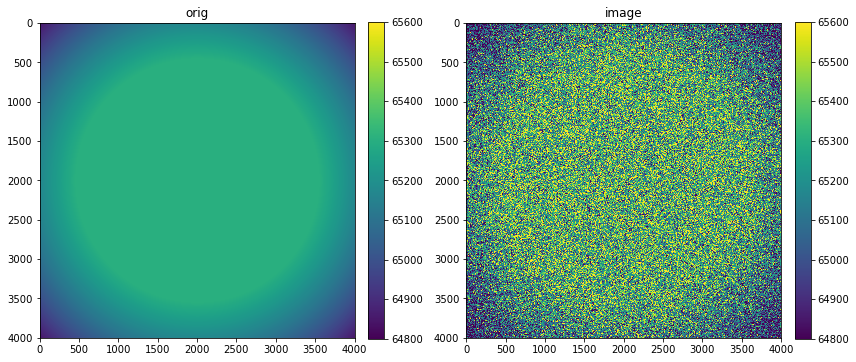

In [26]:
show_images((orig, image), titles=('orig','image'))

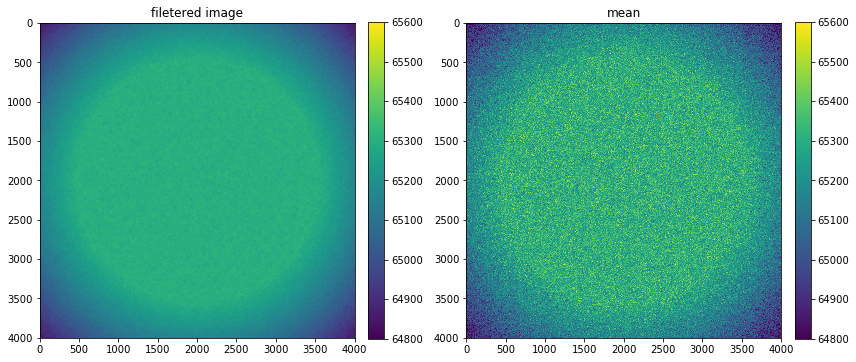

In [27]:
show_images((image_f, mean), titles=('filetered image','mean'))

### Transverse profiles 

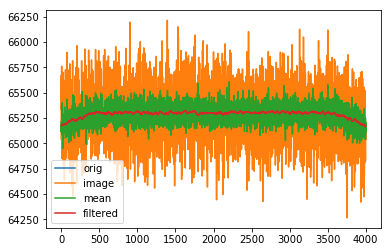

In [37]:
plt.plot(orig[Nx/2,:], label='orig')
plt.plot(image[Nx/2,:], label='image')
plt.plot(mean[Nx/2,:], label='mean')
plt.plot(image_f[Nx/2,:],label='filtered')
plt.legend()

### Prepare arrays for 2d interpolation
- Node coordinates
- Value at node location (using the filtered image)

In [30]:
Nposx = 6
Nposy = 6
xarr = np.linspace(0,Nx-1,Nposx)
yarr = np.linspace(0,Ny-1,Nposy)
print xarr.astype(int), np.size(xarr), np.size(yarr), np.size(xarr)*np.size(yarr)
xtmp = np.repeat(xarr.astype(int),np.size(xarr))
ytmp = np.tile(yarr.astype(int),np.size(yarr))

[   0  799 1599 2399 3199 3999] 6 6 36


In [ ]:
plt.imshow(image_f, vmin=64800, vmax=65600)
plt.colorbar()
plt.scatter(xtmp, ytmp, marker='+', color='red')

In [41]:
node_val = [[image_f[x][y] for y in yarr.astype(int) ] for x in xarr.astype(int)]

### Cubic spline interpolation between nodes

In [52]:
from scipy import interpolate
f = interpolate.interp2d(xarr, yarr, node_val, kind='cubic')

In [53]:
xarr2 = range(0,Nx,1)
yarr2 = range(0,Ny,1)
recons = f(xarr2, yarr2)


### Displaying reconstructed beam image from interpolation between nodes...

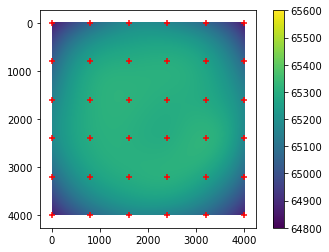

In [54]:
plt.imshow(recons, vmin=64800, vmax=65600)
plt.colorbar()
plt.scatter(xtmp, ytmp, marker='+', color='red')


### ... and residuals w.r.t origin image

- Reconstruction at the per mil level OK provided enough nodes are used

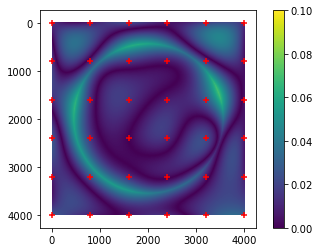

In [55]:
plt.imshow(np.abs(orig-recons)*100./orig, vmin=0., vmax=0.1)
plt.colorbar()
plt.scatter(xtmp, ytmp, marker='+', color='red')


### Repeat 100 times -  check no realisation deviates from per mil reconstruction 

In [57]:
from scipy.ndimage import filters as f
from scipy import interpolate as interp

Ntry = 100

residue=np.empty(Ntry)
for i in np.arange(Ntry):
    image = make_real_beam_image(orig, Nx=Nx, Ny=Ny)
    image_f = f.uniform_filter(image,30)
    node_val = [[image_f[x][y] for y in yarr ] for x in xarr]
    image_interp = interp.interp2d(xarr, yarr, node_val, kind='cubic')
    recons = image_interp(xarr2, yarr2)
    residue[i] = max(np.array(np.abs(orig-recons)*100./orig).flatten())



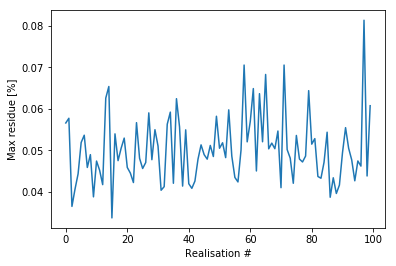

In [58]:
plt.plot(residue)
plt.ylabel('Max residue [%]')
plt.xlabel('Realisation #')